Analyse des données

Préparation des données avec pandas


In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import polars as pl
import pandas as pd
pd.set_option('display.float_format', lambda x: f'{x :.2f}')
from cleaner import DataCleaner
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tools import (
    logging,
    bins_generator,
    import_datasets,
    decode_clean
)
import eda_movies as eda

In [2]:
link = "big_dataframe/movies.csv"
df = eda.eda_movies(link)

2023-10-26 10:52:15 INFO     Pandas loaded ! Importing movies...
2023-10-26 10:52:16 INFO     Fixing N values...
2023-10-26 10:52:16 INFO     Fixing encoding values...
2023-10-26 10:52:16 INFO     Cleaned : 0 rows


ADD TMDB
AND
AKAS

In [3]:
line = "tmdb_full.csv"
df_imdb = pd.read_csv(line)

#  Je merge les deux bd
merged = pd.merge(
    df,
    df_imdb,
    left_on="titre_id",
    right_on="imdb_id",
    how="left"
)
logging.info(f"Cleaned : {len(df) - len(merged)} rows")

# status
# popularity
# revenue
drop = [
    "adult",
    "backdrop_path",
    "budget",
    "genres",
    "homepage",
    "id",
    "imdb_id",
    "original_title",
    "overview",
    "poster_path",
    "release_date",
    "runtime",
    "tagline",
    "title",
    "video",
    "vote_average",
    "vote_count",
    "production_companies_name",
    "production_companies_country"
]
#  Je drop les colonnes
merged = merged.drop(drop, axis=1)
max_ = merged.isna().sum()
logging.info(f"Cleaned NaN Value : {max_.max()}")

# https://fr.wikipedia.org/wiki/D%C3%A9mographie_de_la_Creuse
# https://fr.statista.com/statistiques/498200/preference-films-etrangers-vo-vf-france/
merged = merged.dropna()

C:\Users\morga\AppData\Local\Temp\ipykernel_29704\3551543100.py:2: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df_imdb = pd.read_csv(line)
2023-10-26 10:52:21 INFO     Cleaned : 0 rows
2023-10-26 10:52:21 INFO     Cleaned NaN Value : 108679


In [4]:
merged["spoken_languages"] = np.where(merged["spoken_languages"] == "[]", np.nan, merged["spoken_languages"])
merged["production_countries"] = np.where(merged["production_countries"] == "[]", np.nan, merged["production_countries"])
logging.info(f"Length dataframe merged with tmdb : {len(merged)}")

2023-10-26 10:52:24 INFO     Length dataframe merged with tmdb : 185564


In [5]:
merged = merged.dropna()
logging.info(f"Length dataframe merged cleaned : {len(merged)}")

merged["production_countries"] = merged["production_countries"].apply(decode_clean).str.split()
merged["spoken_languages"] = merged["spoken_languages"].apply(decode_clean).str.split()

# Importation Akas !
akas = import_datasets("movies_datasets/title_akas.tsv", types="pandas", sep="\t")
condi = (
    akas["region"] == 'FR'
)

akas = akas[condi]
region_only = akas[["titleId", "region"]]

#  Merge de akas avec la base de donnée merged (df movies inclus)
logging.info("Merging tmdb and akas dataframes...")
added_region = pd.merge(
    merged,
    region_only,
    left_on="titre_id",
    right_on="titleId"
)
df = added_region

logging.info("Drop all duplicated movies...")
df.drop_duplicates(subset=["titre_id"], keep="first", inplace=True)

# Conserver les films realeased uinqiuement.
condi = (
    df["status"] == "Released"
)
df = df[condi]

2023-10-26 10:52:26 INFO     Length dataframe merged cleaned : 149505
2023-10-26 10:52:26 INFO     Pandas loaded ! Importing title_akas...
c:\Users\morga\OneDrive\AppData\Bureau\WildCodeSchool\z_project_2\tools.py:94: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(datas, sep=sep, encoding="iso-8859-1")
2023-10-26 10:52:56 INFO     Merging tmdb and akas dataframes...


In [6]:
df = df.copy()


In [7]:
df = eda.split_columns(df, "titre_genres")

2023-10-26 10:53:06 INFO     Titre_genres splited !


In [8]:
print(f"Top most viewed genre by movies : {eda.get_top_genres(df)}")

Top most viewed genre by movies : Drama


In [9]:
df = eda.apply_decade_column(df)

2023-10-26 10:53:09 INFO     15 cuts created, from 1900 to 2029


In [10]:
df = eda.drop_nan_values(df)

2023-10-26 10:53:10 INFO     Cleaned : 198 rows


In [11]:
df.isnull().sum()

titre_id                0
titre_str               0
titre_date_sortie       0
titre_duree             0
titre_genres            0
rating_avg              0
rating_votes            0
original_language       0
popularity              0
production_countries    0
revenue                 0
spoken_languages        0
status                  0
titleId                 0
region                  0
cuts                    0
dtype: int64

In [12]:
df.shape

(53002, 16)

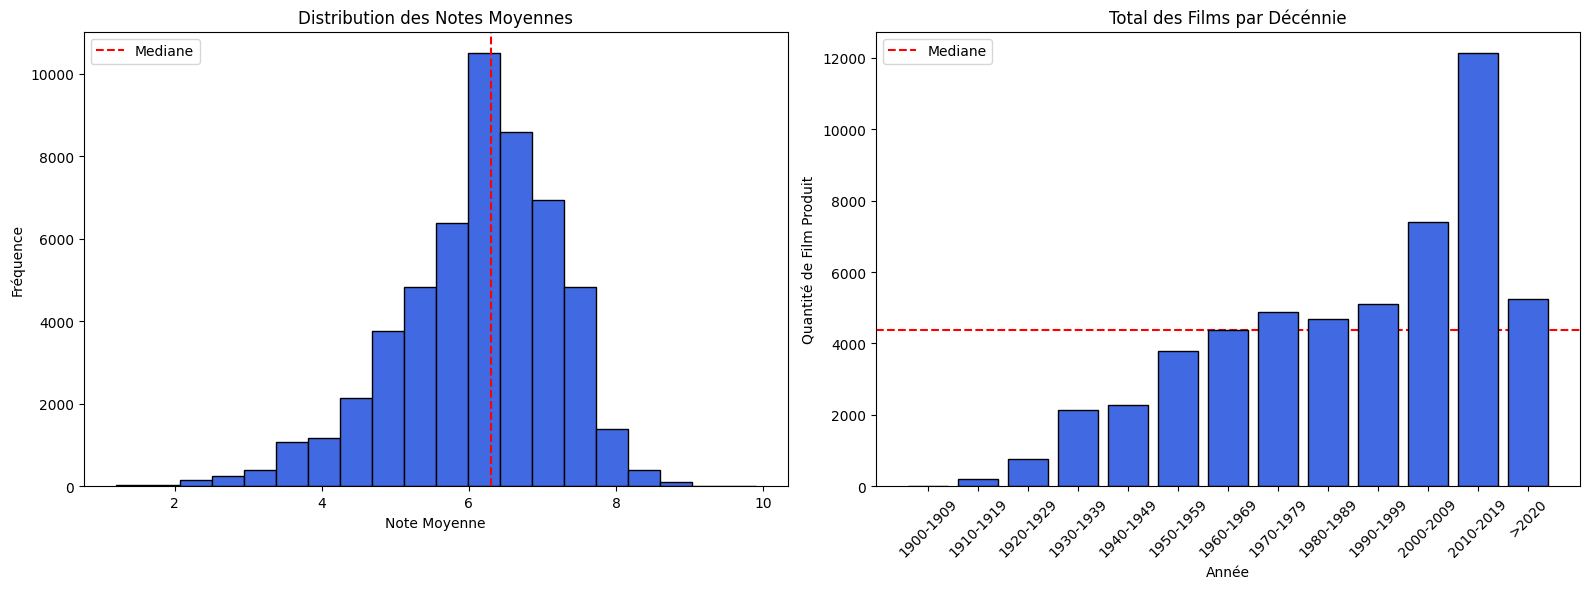

In [13]:
eda.show_total_films_decade(df)

**A partir d'ici nous pouvons definir notre angle d'attaque**
=


**Delete les films en dessous de 1960**

In [16]:
condi =(
    df["titre_date_sortie"] < 1960
)
df = df[~condi].reset_index(drop='index')

In [17]:
condi =(
    df["rating_avg"] < 5
)
df = df[~condi].reset_index(drop='index')

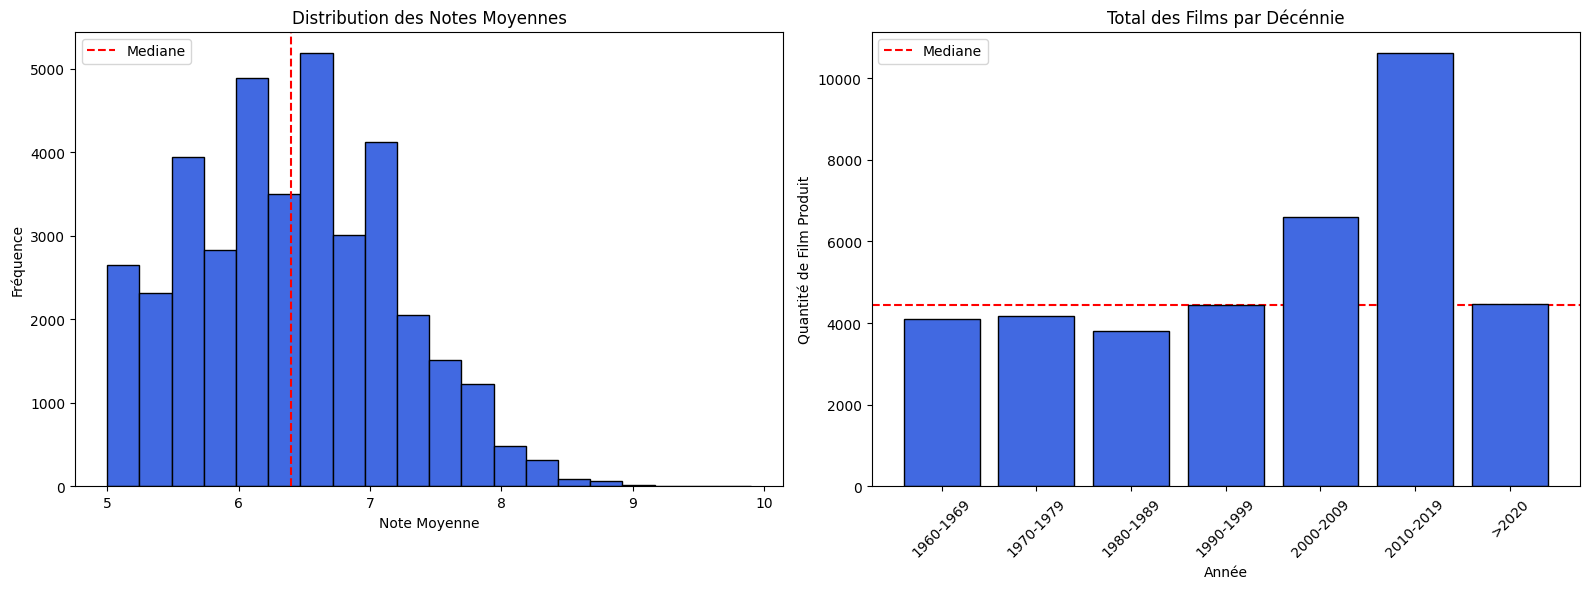

In [18]:
eda.show_total_films_decade(df)

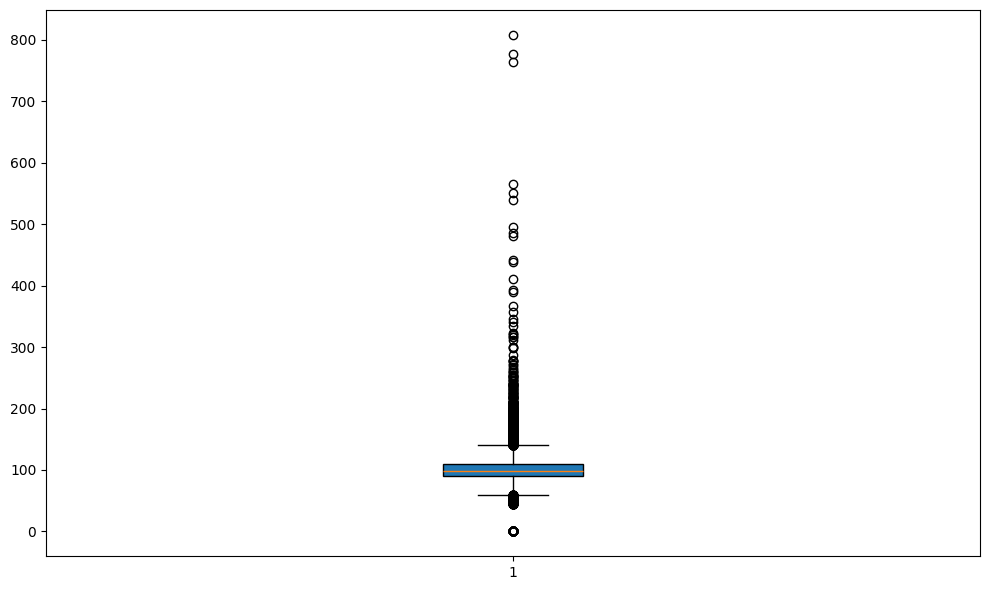

In [19]:
plt.figure(figsize=(10, 6))
plt.boxplot(
    df["titre_duree"],
    patch_artist=True
)
plt.tight_layout()
plt.show()

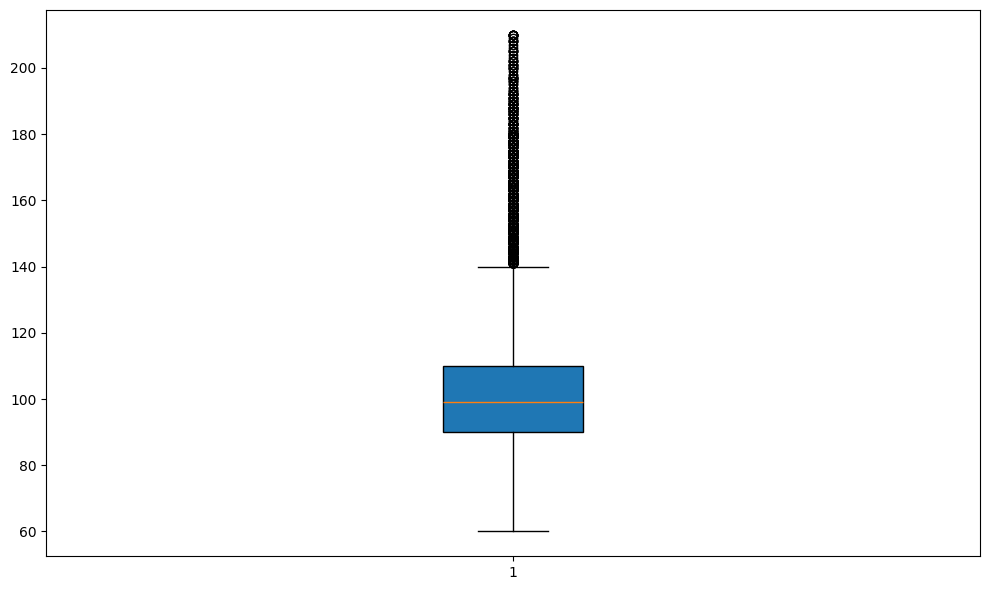

In [20]:
condi =(
    (df["titre_duree"] < 60) | (df["titre_duree"] > 210)
)
df = df[~condi].reset_index(drop='index')
df

plt.figure(figsize=(10, 6))
plt.boxplot(
    df["titre_duree"],
    patch_artist=True
)
plt.tight_layout()
plt.show()

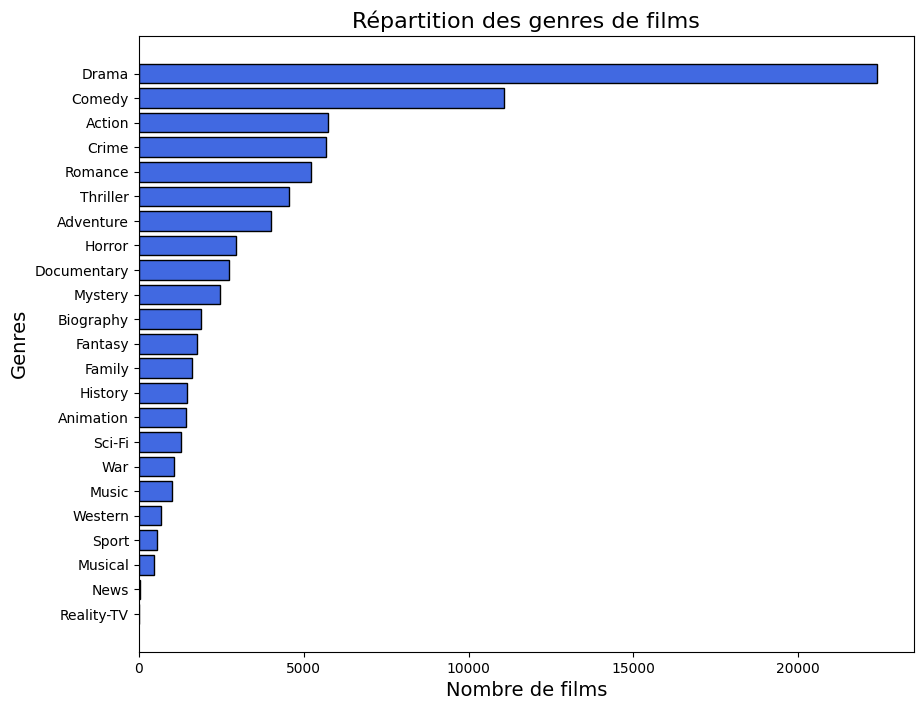

In [21]:
total_genres = df.explode('titre_genres')['titre_genres'].value_counts()

plt.figure(figsize=(10, 8))
plt.barh(
    total_genres.index,
    total_genres.values,
    color='royalblue',
    edgecolor='black'
)
plt.title('Répartition des genres de films', fontsize=16)
plt.xlabel('Nombre de films', fontsize=14)
plt.ylabel('Genres', fontsize=14)
plt.gca().invert_yaxis()
plt.show()

In [22]:
df[df['titre_str'].str.contains("Titanic")]

,titre_id,titre_str,titre_date_sortie,titre_duree,titre_genres,rating_avg,rating_votes,original_language,popularity,production_countries,revenue,spoken_languages,status,titleId,region,cuts
7191,tt0081400,Raise the Titanic,1980,115,"[Action, Adventure, Drama]",5.10,5251,en,10.43,[GB],7000000.00,[en],Released,tt0081400,FR,1980-1989
13419,tt0120338,Titanic,1997,194,"[Drama, Romance]",7.90,1249787,en,108.78,[US],2264162353.00,"[en,fr,de,sv,it,ru]",Released,tt0120338,FR,1990-1999
13918,tt0129923,The Chambermaid on the Titanic,1997,101,"[Drama, Romance]",6.60,1451,fr,2.69,"[FR,DE,IT,ES]",0.00,"[en,fr,hu]",Released,tt0129923,FR,1990-1999
24795,tt13328824,The Blind Man Who Did Not Want to See Titanic,2021,82,"[Comedy, Drama, Romance]",7.50,1473,fi,4.12,[FI],0.00,[fi],Released,tt13328824,FR,>2020


In [23]:
df.shape

(37564, 16)

In [24]:

df["production_countries"] = df["production_countries"].apply(decode_clean).str.split()
df["spoken_languages"] = df["spoken_languages"].apply(decode_clean).str.split()

AttributeError: 'list' object has no attribute 'replace'

In [ ]:
df

In [ ]:
print(len(t))
df = t.dropna()

df = df[df["rating_avg"] > df["rating_avg"].median()]
print(len(df))
df

In [ ]:
condi = (
    akas["region"] == 'FR'
)

akas = akas[condi]

In [ ]:
region_only = akas[["titleId", "region"]]
akas[akas["titleId"] == "tt18260116"]

In [ ]:
added_region = pd.merge(
    df1,
    region_only,
    left_on="titre_id",
    right_on="titleId"
)
added_region

In [ ]:
added_region.drop_duplicates(subset=["titre_id"], keep="first", inplace=True)

In [ ]:
added_region[added_region["titre_id"] == "tt18260116"]

In [ ]:
condi = (
    added_region["status"] == "Released"
)

added_region[condi]

In [ ]:
added_region.head(50)

In [ ]:
# added_region[added_region["titre_str"].str.contains("Star W")]

In [ ]:

# condi = (
#     df1["original_language"].isna()
# )
# p = df1[condi]

# p


# pp = df1.copy()
# pp
# genre_mode = pp['titre_genres'].explode()
# genre_mode.mode()
# # # p.to_csv("tttt.csv", index=False)

In [ ]:
# # On filtre les films qui sont déja sortie au cinéma
# year_now = datetime.now().year

# condi = (
#     (df["person_job"].str.contains("act")) &
#     (df["titre_date_sortie"] <= year_now)
# )
# df = df[condi]
# actor = df.copy()

# """
# La moyenne d'age des acteurs a la date de sortie du film.
# Nous calculons la mediane sur cette base.

# other KPI, calcul la moyenne des ages en fonction de l'année

# """
# # ajouter colonne age pour les personnes
# actor["person_age"] = np.where(
#     (actor["person_birthdate"] > 1800) &
#     (actor["titre_date_sortie"] > 1800) &
#     (actor["titre_date_sortie"] - actor["person_birthdate"] >= 0),
#     (actor["titre_date_sortie"] - actor["person_birthdate"]),
#     0
# )
# actor.tail()

In [ ]:
# df.info()

In [ ]:
# """
# imagine un fonction, qui prendrais en argument une liste de date de
# titre de sortie et retourne la moyenne d'age de ces années des acteurs.

# # Quels sont les acteurs les plus présents ?
# # À quelle période ?
# La durée moyenne des films s'allonge ou se raccourcit avec les années ?
# Les acteurs de série sont-ils les mêmes qu'au cinéma ?
# # Les acteurs ont en moyenne quel âge ?
# Quels sont les films les mieux notés ?
# Partagent-ils des caractéristiques communes ? etc...

# """

# bins, names = bins_generator(actor["titre_date_sortie"].max())

# actor["cuts"] = pd.cut(
#     actor["titre_date_sortie"],
#     bins=bins,
#     labels=names
# )

# actor_median = []
# for date in names[1:]:
#     condi = (
#         (actor["person_age"] != 0) &
#         (actor["cuts"] == date)
#     )
#     # print(f"Mediane for person_age {date} :", actor["person_age"][condi].median())
#     actor_median.append(actor["person_age"][condi].median())

# plt.figure(figsize=(10,6))
# plt.bar(names[1:], actor_median, color="royalblue")
# plt.xlabel("Années des film")
# plt.ylabel("Mediane")
# plt.title("Mediane acteur vs année")
# plt.xticks(rotation=45)
# plt.tight_layout()

In [ ]:
# # Top 5 des acteurs all time !
# print(actor["person_name"].value_counts().head(5))
# # Bottom 5 des acteurs all time !
# print(actor["person_name"].value_counts().tail(5))

In [ ]:
# # Top 5 actors by years
# for date in names[1:]:
#     top5 = actor['person_name'][condi].value_counts().head(5)
#     condi = (
#         (actor["cuts"] == date)
#     )
#     top5_str = '\n'.join(str(top5).split('\n')[:-1])

#     print(f"Top 5 actors by movies for {date}\n{'-'*20}\n{top5_str}")
#     print("-"*20)


In [ ]:
# #  World record of the longest documentary
# # source :https://fr.wikipedia.org/wiki/Ambianc%C3%A9
# longest = actor[actor["titre_duree"] == 43200]
# n = longest[["titre_str", "titre_duree"]].iloc[0]
# heure = n["titre_duree"] // 60
# jours = heure // 24
# print(f"Le film le plus long est {n['titre_str']} d'une durée de {heure} heures soit {jours} jours")
# # All time median for duration
# print(f"All time duration median : {round(actor['titre_duree'].median())} minutes")

In [ ]:
# # Median duration for movies between years.
# nodup = actor[~actor["titre_str"].duplicated(keep="first")]

# for date in names[1:]:
#     condi = (
#         (nodup["cuts"] == date)
#     )
#     med = round(nodup["titre_duree"][condi].median())
#     print(f"Median durations for movies {date}\nMedian for this years is {med} minutes")
#     print("-"*20)

In [ ]:
# print(len(yy[yy["titre_date_sortie"].isna()]))
# yy["titre_date_sortie"].fillna(1678, inplace=True)
# yy["person_birthdate"] = yy["person_birthdate"].astype(int).replace(0, 1678)
# condi = (
#     yy["person_birthdate"] < 1678
# )

# yy.loc[condi, "person_birthdate"] = 1678
# datime_col = ["titre_date_sortie", "person_birthdate"]
# for time in datime_col:
#     yy[time] = pd.to_datetime(yy[time], format="%Y")
# yy["titre_date_sortie"] = yy["titre_date_sortie"].dt.year